In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from RateTraining import *
from RateTraining import RateTraining
from LIFTraining import *

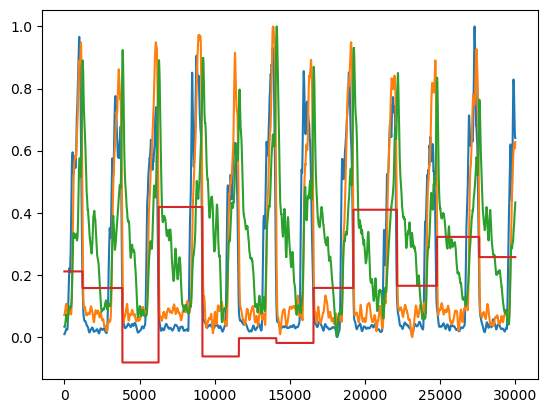

In [3]:
raw_waveforms = np.transpose(np.load("raw_form.npy"))
freqs = np.load("fin.npy")

fin = freqs[0:30000]
hfout = raw_waveforms[0][0:30000]
pfout = raw_waveforms[1][0:30000]
vfout = raw_waveforms[2][0:30000]

fout = np.vstack((hfout, pfout, vfout))

plt.plot(hfout)
plt.plot(pfout)
plt.plot(vfout)
plt.plot(fin)

[0, 1203, 3854, 6265, 9177, 11607, 14097, 16571, 19222, 22125, 24783, 27599]


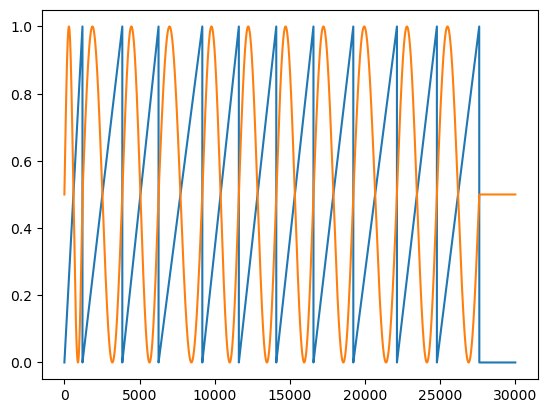

In [4]:
steps = [0]
for i in range(1, len(freqs)):
    if freqs[i] != freqs[i - 1]:
        steps.append(i)
print(steps)

phase = np.zeros(len(freqs))
for i in range(1, len(steps)):
    phase[steps[i - 1]:steps[i]] = np.linspace(0, 2 * np.pi, num = steps[i] - steps[i - 1])

phaseinp = phase / (2 * np.pi)
psininp = (np.sin(phase) + 1) / 2
plt.plot(phaseinp)
plt.plot(psininp)

In [5]:
start = 1203
stop = 22125
trainstop = 11607

In [10]:
rpars = create_default_params_rate()
rpars['net_size'] = 2000
rpars['total_time'] = stop - start
rpars['runtime'] = stop - start

In [11]:
uhfoutd = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), hfout[start:stop])
upfoutd = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), pfout[start:stop])
uvfoutd = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), vfout[start:stop])

uhfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), hfout[start:stop])
upfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), pfout[start:stop])
uvfout = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), vfout[start:stop])

ufind = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), fin[start:stop])
ufin = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), fin[start:stop])

uphaseind = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), phaseinp[start:stop])
uphasein = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), phaseinp[start:stop])

upsinind = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), psininp[start:stop])
upsinin = np.outer(sp.stats.uniform.rvs(size = rpars['net_size']), psininp[start:stop])

In [12]:
dnet = RateTraining(rpars)

In [13]:
ufoutd = uhfoutd + upfoutd + uvfoutd
# stabilize network before creating auxillary targets
for i in range(3):
    dnet.runGPU(ufoutd + upsinind)

_, Hxd = dnet.runGPU(ufoutd + upsinind)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

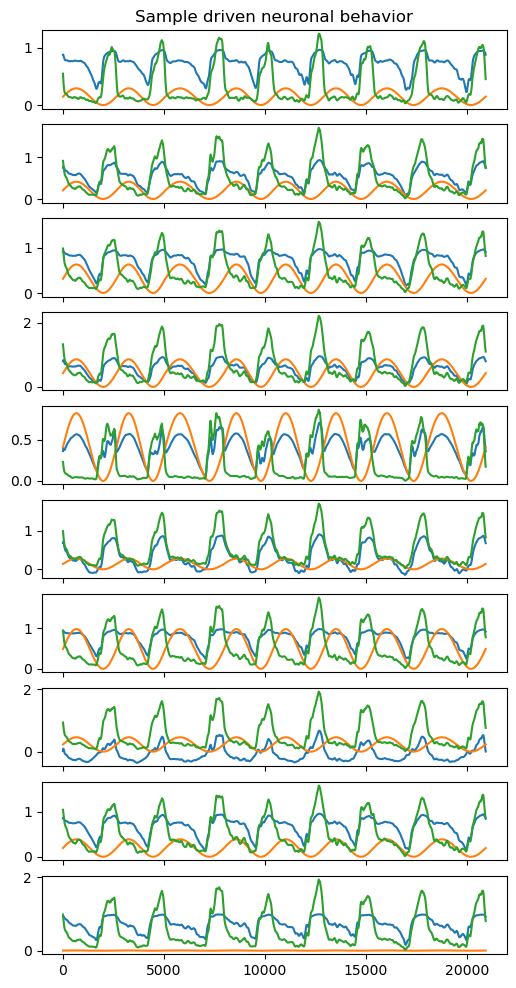

In [14]:
n_plot = 10

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hxd[i])
    
    axs[i].plot(upsinind[i])
    axs[i].plot(ufoutd[i])

axs[0].set_title("Sample driven neuronal behavior")

In [15]:
ufout = uhfout + upfout + uvfout

gain = 1
aux_targs = Hxd * gain + ufout
np.shape(aux_targs)

(2000, 20922)

In [16]:
lifpars = create_default_params_LIF()

In [17]:
lifpars['net_size'] = 2000
lifpars['num_out'] = 3
lifpars['runtime'] = stop - start # 10404
lifpars['total_time'] = trainstop - start
lifpars['training_loops'] = 1000

In [18]:
lifnet = LIFTraining(lifpars)

In [19]:
# stabilize network
for i in range(3):
    lifnet.runGPU(upsinin)

In [20]:
lifnet.trainGPU(upsinin, aux_targs, fout)

In [21]:
voltage, slow, fast = lifnet.runGPU(upsinin)

Text(0.5, 1.0, 'Behavior after training')

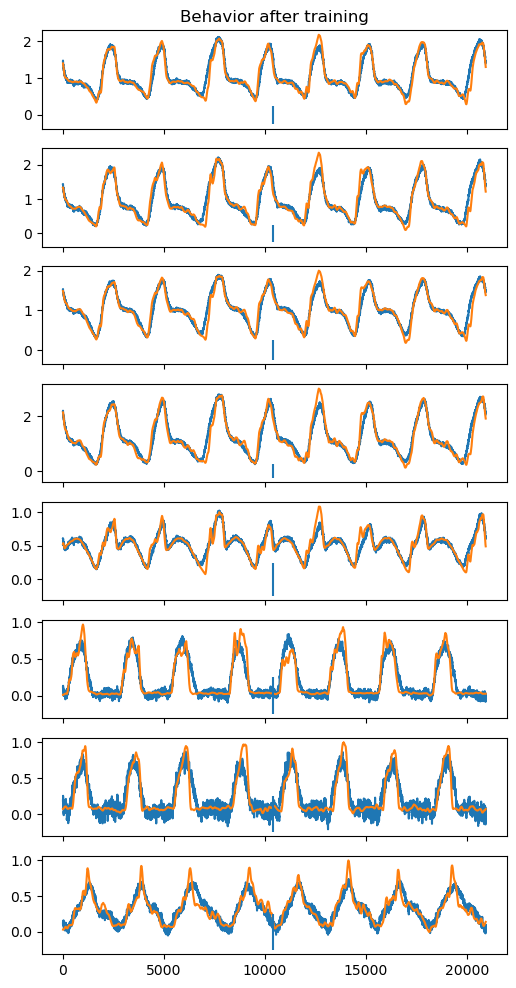

In [22]:
Jslow = np.dot(lifnet.Js, slow)
wout = np.dot(lifnet.W_out, slow)
tot = stop - start
n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot + 3, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(aux_targs[i][0:tot])
    # axs[i].plot(uphasein[i][0:10404])
    axs[i].vlines(lifnet.T, -0.25, 0.25)
for i in range(lifnet.num_outs):
    axs[n_plot + i].plot(wout[i])
    axs[n_plot + i].plot(fout[i, 0:tot])
    axs[n_plot + i].vlines(lifnet.T, -0.25, 0.25)

axs[0].set_title("Behavior after training")

Text(0.5, 1.0, 'Fast synapses after training')

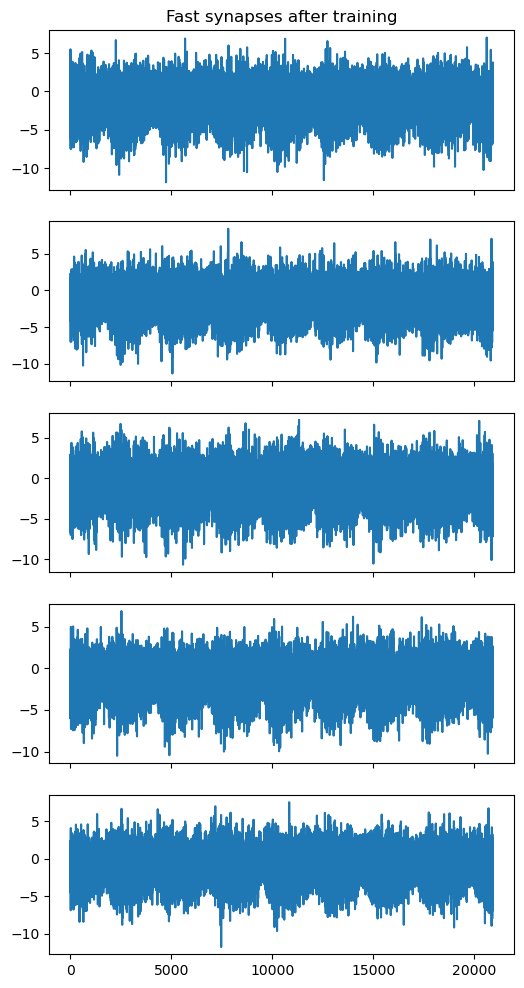

In [23]:
Jfast = np.dot(lifnet.Jf, fast)

n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jfast[i])
axs[0].set_title("Fast synapses after training")

Text(0.5, 1.0, 'Membrane potential (voltage) after training')

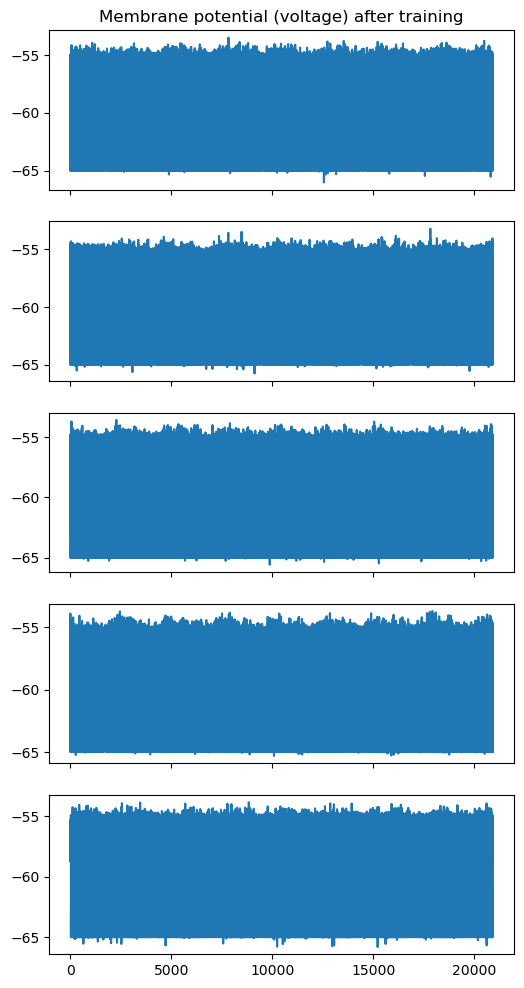

In [24]:
n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Membrane potential (voltage) after training")

In [37]:
np.shape(voltage)

(2000, 20922)

In [48]:
spks = voltage > lifnet.v_thr

times = np.argwhere(spks)
np.shape(times)

(1187951, 2)

In [52]:
times
spkt = []
for i in range(lifnet.N):
    spkt.append(times[times[:, 0]==i, 1])


In [53]:
spkt

[array([    0,    16,    45,    65,    88,   114,   133,   154,   176,
          199,   219,   240,   267,   289,   313,   331,   358,   379,
          401,   422,   444,   463,   488,   510,   533,   558,   572,
          592,   616,   633,   653,   674,   694,   710,   733,   757,
          776,   802,   825,   844,   865,   885,   906,   933,   953,
          980,  1003,  1022,  1049,  1069,  1091,  1114,  1134,  1162,
         1181,  1205,  1226,  1248,  1270,  1293,  1328,  1355,  1383,
         1412,  1438,  1475,  1510,  1539,  1580,  1615,  1651,  1691,
         1733,  1772,  1820,  1862,  1899,  1922,  1951,  1977,  2014,
         2042,  2070,  2104,  2123,  2144,  2167,  2189,  2210,  2231,
         2254,  2280,  2301,  2325,  2353,  2376,  2393,  2412,  2435,
         2453,  2477,  2498,  2524,  2545,  2568,  2585,  2606,  2629,
         2647,  2673,  2695,  2721,  2743,  2769,  2796,  2820,  2838,
         2859,  2879,  2900,  2922,  2947,  2972,  2990,  3009,  3030,
      

In [73]:
np.shape(wout)

(3, 20922)

(0.0, 20922.0)

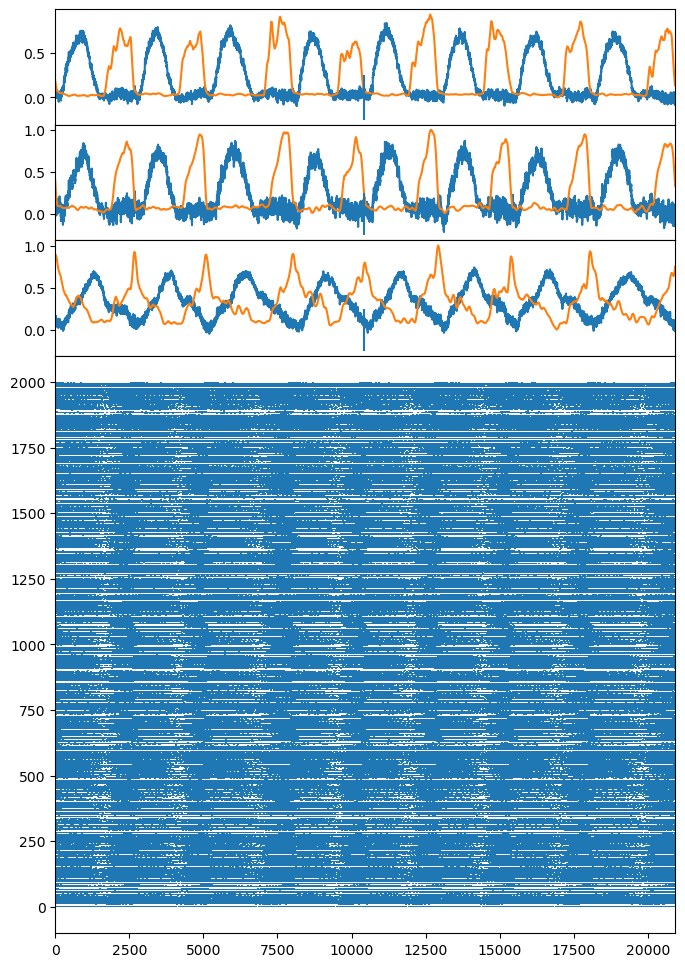

In [75]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 12), 
                        gridspec_kw=dict(hspace=0, height_ratios=[0.2, 0.2, 0.2, 1]))

for i in range(lifnet.num_outs):
    axs[i].plot(wout[i, :])
    axs[i].plot(fout[i, 0:tot])
    axs[i].vlines(lifnet.T, -0.25, 0.25)

axs[3].eventplot(spkt);
axs[0].set_xlim([0, tot])

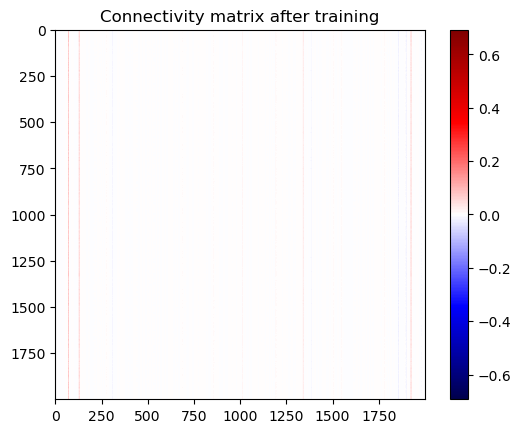

In [25]:
m = max(-1*np.min(lifnet.Js), np.max(lifnet.Js))

plt.imshow(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


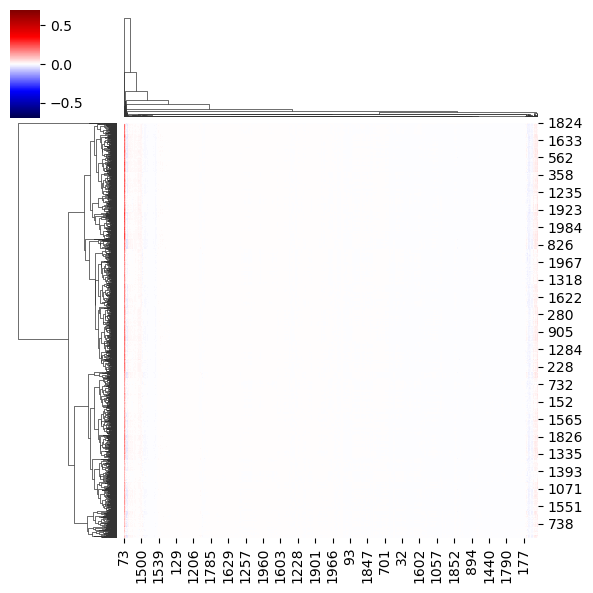

In [26]:
sns.clustermap(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m, figsize = (6, 6))
